In [1]:
import pandas as pd
import numpy as np
from pybdm import BDM
#from pybdm import PartitionCorrelated
from pybdm import PartitionRecursive
from statistics import harmonic_mean

In [2]:
exp_path = "seriesWithLLMs_ext.csv"#"RandomBinarySeriesWithLLMs.csv"#
bin_seq_df = pd.read_csv(exp_path)
bin_seq_df

,sequence,chatgpt_4.5-formula,chatgpt_4.5-formula-eval,chatgpt_4.5-formula-correctness,chatgpt_4.5-formula-copy_seq,chatgpt_4.5-formula-ordinal,deepseek-formula,deepseek-formula-eval,deepseek-formula-correctness,deepseek-formula-copy_seq,...,o1_preview-formula-correctness,o1_preview-formula-copy_seq,mistral-program,mistral-program-print,mistral-program-correctness,mistral-formula,mistral-formula-eval,mistral-formula-copy_seq,mistral-formula-ordinal,mistral-formula-correctness
0,"1,1,0,0,0,1,0,0,0,0,1,0","[""[int(i in [0,1,5,10]) for i in range(12)]"",""...","1,1,0,0,0,1,0,0,0,0,1,0",True,False,True,"[1,1,0,0,0,1,0,0,0,0,1,0]","1,1,0,0,0,1,0,0,0,0,1,0",True,True,...,True,False,"print([1,1,0,0,0,1,0,0,0,0,1,0])",True,True,"[1,1,0,0,0,1,0,0,0,0,1,0]","1,1,0,0,0,1,0,0,0,0,1,0",True,False,True
1,"0,0,0,1,0,1,1,0,1,0,1,1","[""[int(i in [3,5,6,8,10,11]) for i in range(12...","0,0,0,1,0,1,1,0,1,0,1,1",True,False,True,"[0,0,0,1,0,1,1,0,1,0,1,1]","0,0,0,1,0,1,1,0,1,0,1,1",True,True,...,True,False,"print([0,0,0,1,0,1,1,0,1,0,1,1])",True,True,"[0,0,0,1,0,1,1,0,1,0,1,1]","0,0,0,1,0,1,1,0,1,0,1,1",True,False,True
2,"1,0,0,0,0,1,1,1,1,0,0,1","[""[int(i in [0,5,6,7,8,11]) for i in range(12)...","1,0,0,0,0,1,1,1,1,0,0,1",True,False,True,"[1,0,0,0,0,1,1,1,1,0,0,1]","1,0,0,0,0,1,1,1,1,0,0,1",True,True,...,True,False,"print([1,0,0,0,0,1,1,1,1,0,0,1])",True,True,"[1,0,0,0,0,1,1,1,1,0,0,1]","1,0,0,0,0,1,1,1,1,0,0,1",True,False,True
3,"1,1,1,1,1,1,1,1,0,1,0,0","[""[int(i<8 or i==9) for i in range(12)]"",""[1]*...","1,1,1,1,1,1,1,1,0,1,0,0",True,False,True,"[1,1,1,1,1,1,1,1,0,1,0,0]","1,1,1,1,1,1,1,1,0,1,0,0",True,True,...,True,False,"print([1,1,1,1,1,1,1,1,0,1,0,0])",True,True,"[1,1,1,1,1,1,1,1,0,1,0,0]","1,1,1,1,1,1,1,1,0,1,0,0",True,False,True
4,"1,0,1,1,0,1,0,1,0,1,0,0","[""[int(i in [0,2,3,5,7,9]) for i in range(12)]...","1,0,1,1,0,1,0,1,0,1,0,0",True,False,True,"[1,0,1,1,0,1,0,1,0,1,0,0]","1,0,1,1,0,1,0,1,0,1,0,0",True,True,...,True,False,"print([1,0,1,1,0,1,0,1,0,1,0,0])",True,True,"[1,0,1,1,0,1,0,1,0,1,0,0]","1,0,1,1,0,1,0,1,0,1,0,0",True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,"187,218,260,295,301,000,000,000,000,000",***,***,False,False,False,***,***,False,False,...,False,True,NaN,NaN,NaN,***,1.87E+29,False,False,False
181,"29,63,95,140,150,190,221,437,482,491",***,***,False,False,False,***,***,False,False,...,False,True,NaN,NaN,NaN,***,"29,63,95,140,150,190,221,437,482,491",False,False,True
182,"3,11,84,144,156,177,188,199,229,284",***,***,False,False,False,***,***,False,False,...,False,True,NaN,NaN,NaN,***,"3,11,84,144,156,177,188,199,229,284",False,False,True
183,"26,94,98,137,176,301,323,330,372,444",***,***,False,False,False,***,***,False,False,...,False,True,NaN,NaN,NaN,***,"26,94,98,137,176,301,323,330,372,444",False,False,True


In [3]:
models = ['gpt_4o', 'claude_3.5', 'gpt_4o_mini', 'cursor_small', 'gemini', 'meta', 
          'o1_mini', 'o1_preview', 'mistral', 'qwen', 'grok_3', 'deepseek', 'claude_3.7', 'chatgpt_4.5']#,'BDM/CTM']

In [4]:
def ascii_to_binary_list(text):
    binary_list = []
    for char in text:
        #print('text:', text, ' char: ', char)
        # Convert each character to its binary representation
        binary_representation = format(ord(char), '08b')
        # Extend the binary_list with the numerical digits of the binary representation
        binary_list.extend([int(bit) for bit in binary_representation])
    return np.array(binary_list).astype(np.int8)

def bdm_compressed(text):
    bdm = BDM(ndim=1,partition=PartitionCorrelated)
    return bdm.bdm(ascii_to_binary_list(text))

In [5]:
# def tst_calc(v1,v2):
#     v3 = v2[:3]*np.array([1,0.5,0.25])
#     return np.sum(v1[:3]*v3)-v1[-1]

# test_vals=[]
# dd=3
# bdm = BDM(ndim=1,partition=PartitionRecursive)
# for mdl in models:#[:-1]:
#     sep_df= bin_seq_df[['sequence',f'{mdl}-formula',f'{mdl}-formula-correctness',f'{mdl}-formula-ordinal',f'{mdl}-formula-copy_seq']].copy()
#     sep_df["bdm_formula"]=[bdm.bdm(ascii_to_binary_list(x)) for x in sep_df[f'{mdl}-formula'].to_numpy()]
#     sep_df["bdm_input"]=[bdm.bdm(ascii_to_binary_list(x)) for x in sep_df['sequence'].to_numpy()]
#     sep_df["bdm_min"] = [bdm.bdm(seq) for seq in np.array([np.array(x.split(",")).astype(np.int8) for x in sep_df["sequence"].to_numpy()])]
#     df_c_n_n = sep_df[sep_df[f"{mdl}-formula-correctness"] & ~sep_df[f"{mdl}-formula-ordinal"] & ~sep_df[f"{mdl}-formula-copy_seq"]]
#     df_c_o = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-ordinal"]]
#     df_c_p = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-copy_seq"]]
#     df_i = sep_df[~sep_df[f"{mdl}-formula-correctness"]]
#     v1=np.array([len(x)/100 for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
#     v2 = []
#     for x in [df_c_n_n,df_c_o,df_c_p,df_i]:
#         datax = (x["bdm_min"]/x["bdm_formula"]).to_numpy()
#         if len(datax)>0:
#             v2.append(harmonic_mean(datax))
#         else:
#             v2.append(0)
#     v2 = (np.nan_to_num(np.array(v2)))
#     tst = tst_calc(v1,v2)
#     test_vals.append([mdl]+list(v1)+list(v2[:3])+[tst])

In [6]:
def tst_calc(v1,v2):
    v3 = v2[:3]*np.array([1,0.5,0.25])
    return np.sum(v1[:3]*v3)-v1[-1]

def process_sequence(seq_str):
    """
    Process a sequence string to prepare it for BDM calculation.
    - If it's already a binary sequence (0s and 1s), split by commas and convert to int8
    - If it's a numeric sequence, convert each number to binary digits and flatten
    """
    elements = seq_str.split(",")
    #print('processing: ', elements)
    # Check if all elements are binary (0 or 1)
    is_binary = all(e.strip() in ['0', '1'] for e in elements)
    
    if is_binary:
        # Already binary, just convert to int8 array
        return np.array(elements).astype(np.int8)
    else:
        # Convert numeric sequence to binary representation
        binary_digits = []
        for num in elements:
            try:
                # Convert to integer and then to binary string (removing '0b' prefix)
                bin_str = bin(int(num.strip()))[2:]
                # Convert each binary digit to int and add to list
                binary_digits.extend([int(digit) for digit in bin_str])
            except ValueError:
                # If conversion fails, use empty list
                pass
        return np.array(binary_digits).astype(np.int8)

test_vals=[]
dd=3
bdm = BDM(ndim=1,partition=PartitionRecursive)
for mdl in models:#[:-1]:
    print('processing model: ', mdl)
    sep_df= bin_seq_df[['sequence',f'{mdl}-formula',f'{mdl}-formula-correctness',f'{mdl}-formula-ordinal',f'{mdl}-formula-copy_seq']].copy()
    sep_df["bdm_formula"]=[bdm.bdm(ascii_to_binary_list(x)) for x in sep_df[f'{mdl}-formula'].to_numpy()]
    sep_df["bdm_input"]=[bdm.bdm(ascii_to_binary_list(x)) for x in sep_df['sequence'].to_numpy()]
    # Modified line to handle both binary and numeric sequences
    sep_df["bdm_min"] = [bdm.bdm(process_sequence(x)) for x in sep_df["sequence"].to_numpy()]
    
    df_c_n_n = sep_df[sep_df[f"{mdl}-formula-correctness"] & ~sep_df[f"{mdl}-formula-ordinal"] & ~sep_df[f"{mdl}-formula-copy_seq"]]
    df_c_o = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-ordinal"]]
    df_c_p = sep_df[sep_df[f"{mdl}-formula-correctness"] & sep_df[f"{mdl}-formula-copy_seq"]]
    df_i = sep_df[~sep_df[f"{mdl}-formula-correctness"]]
    v1=np.array([len(x)/100 for x in [df_c_n_n,df_c_o,df_c_p,df_i]])
    v2 = []
    for x in [df_c_n_n,df_c_o,df_c_p,df_i]:
        datax = (x["bdm_min"]/x["bdm_formula"]).to_numpy()
        if len(datax)>0:
            v2.append(harmonic_mean(datax))
        else:
            v2.append(0)
    v2 = (np.nan_to_num(np.array(v2)))
    tst = tst_calc(v1,v2)
    test_vals.append([mdl]+list(v1)+list(v2[:3])+[tst])

processing model:  gpt_4o
processing model:  claude_3.5
processing model:  gpt_4o_mini
processing model:  cursor_small
processing model:  gemini
processing model:  meta
processing model:  o1_mini
processing model:  o1_preview
processing model:  mistral
processing model:  qwen
processing model:  grok_3
processing model:  deepseek
processing model:  claude_3.7
processing model:  chatgpt_4.5


In [7]:
df_ranking = pd.DataFrame(test_vals)
df_ranking.columns = ["Model","p1","p2","p3","p4","r1","r2","r3","tst"]
df_ranking.sort_values(by=['tst'],ascending=False).set_index(["Model"])



,p1,p2,p3,p4,r1,r2,r3,tst
Model,,,,,,,,
mistral,0.67,0.00,1.00,0.18,1.552832,0.000000,0.115663,0.889313
gpt_4o_mini,0.39,0.00,1.46,0.00,1.550954,0.000000,0.159538,0.663104
claude_3.7,0.40,0.81,0.32,0.32,1.060245,0.032464,0.312693,0.142261
chatgpt_4.5,0.44,1.00,0.00,0.41,1.007959,0.030495,0.000000,0.048750
cursor_small,0.49,0.00,1.00,0.36,0.691022,0.000000,0.141100,0.013876
deepseek,0.59,0.00,1.00,0.26,0.345384,0.000000,0.115663,-0.027308
qwen,0.59,0.00,1.00,0.26,0.204102,0.000000,0.115663,-0.110664
o1_mini,0.52,0.64,0.14,0.55,0.595049,0.058448,0.224202,-0.214024
gemini,0.41,0.00,1.00,0.44,0.255128,0.000000,0.141100,-0.300123


### Make a copy of ranking

In [29]:
from copy import deepcopy
df_ranking2 = deepcopy(df_ranking)
df_ranking2 #.sort_values(by='tst', ascending=False)


,Model,p1,p2,p3,p4,r1,r2,r3,tst
0,gpt_4o,0.41,0.00,0.36,1.08,1.383645,0.000000,0.312577,-0.484573
1,claude_3.5,0.14,0.46,0.00,1.25,0.128716,0.116423,0.000000,-1.205203
2,gpt_4o_mini,0.39,0.00,1.46,0.00,1.550954,0.000000,0.159538,0.663104
3,cursor_small,0.49,0.00,1.00,0.36,0.691022,0.000000,0.141100,0.013876
4,gemini,0.41,0.00,1.00,0.44,0.255128,0.000000,0.141100,-0.300123
5,meta,0.67,0.00,0.00,1.18,0.285003,0.000000,0.000000,-0.989048
6,o1_mini,0.52,0.64,0.14,0.55,0.595049,0.058448,0.224202,-0.214024
7,o1_preview,0.01,0.29,0.14,1.41,2.492853,0.047635,0.224202,-1.370317
8,mistral,0.67,0.00,1.00,0.18,1.552832,0.000000,0.115663,0.889313
9,qwen,0.59,0.00,1.00,0.26,0.204102,0.000000,0.115663,-0.110664


### sort new copy

In [30]:
df_ranking2 = df_ranking2.sort_values(by='tst', ascending=False)
df_ranking2

,Model,p1,p2,p3,p4,r1,r2,r3,tst
8,mistral,0.67,0.00,1.00,0.18,1.552832,0.000000,0.115663,0.889313
2,gpt_4o_mini,0.39,0.00,1.46,0.00,1.550954,0.000000,0.159538,0.663104
12,claude_3.7,0.40,0.81,0.32,0.32,1.060245,0.032464,0.312693,0.142261
13,chatgpt_4.5,0.44,1.00,0.00,0.41,1.007959,0.030495,0.000000,0.048750
3,cursor_small,0.49,0.00,1.00,0.36,0.691022,0.000000,0.141100,0.013876
11,deepseek,0.59,0.00,1.00,0.26,0.345384,0.000000,0.115663,-0.027308
9,qwen,0.59,0.00,1.00,0.26,0.204102,0.000000,0.115663,-0.110664
6,o1_mini,0.52,0.64,0.14,0.55,0.595049,0.058448,0.224202,-0.214024
4,gemini,0.41,0.00,1.00,0.44,0.255128,0.000000,0.141100,-0.300123
0,gpt_4o,0.41,0.00,0.36,1.08,1.383645,0.000000,0.312577,-0.484573


### Scale to 0.1

In [31]:
# Normalize tst values in df_ranking2 to be between 0 and 0.1
df_ranking2['tst'] = (df_ranking2['tst'] - df_ranking2['tst'].min()) / (df_ranking2['tst'].max() - df_ranking2['tst'].min()) * 0.1
df_ranking2


,Model,p1,p2,p3,p4,r1,r2,r3,tst
8,mistral,0.67,0.00,1.00,0.18,1.552832,0.000000,0.115663,0.100000
2,gpt_4o_mini,0.39,0.00,1.46,0.00,1.550954,0.000000,0.159538,0.089989
12,claude_3.7,0.40,0.81,0.32,0.32,1.060245,0.032464,0.312693,0.066939
13,chatgpt_4.5,0.44,1.00,0.00,0.41,1.007959,0.030495,0.000000,0.062801
3,cursor_small,0.49,0.00,1.00,0.36,0.691022,0.000000,0.141100,0.061257
11,deepseek,0.59,0.00,1.00,0.26,0.345384,0.000000,0.115663,0.059435
9,qwen,0.59,0.00,1.00,0.26,0.204102,0.000000,0.115663,0.055746
6,o1_mini,0.52,0.64,0.14,0.55,0.595049,0.058448,0.224202,0.051172
4,gemini,0.41,0.00,1.00,0.44,0.255128,0.000000,0.141100,0.047361
0,gpt_4o,0.41,0.00,0.36,1.08,1.383645,0.000000,0.312577,0.039199


### Append ASI

In [32]:
new_row = {'Model': 'ASI', 'p1': 1, 'p2': 0, 'p3': 0, 'p4': 0, 'r1': 1, 'r2': 0, 'r3': 1, 'tst': 1}
df_ranking2 = pd.concat([df_ranking2, pd.DataFrame([new_row])], ignore_index=True)
df_ranking2 = df_ranking2.sort_values(by='tst', ascending=False)
df_ranking2

,Model,p1,p2,p3,p4,r1,r2,r3,tst
14,ASI,1.00,0.00,0.00,0.00,1.000000,0.000000,1.000000,1.000000
0,mistral,0.67,0.00,1.00,0.18,1.552832,0.000000,0.115663,0.100000
1,gpt_4o_mini,0.39,0.00,1.46,0.00,1.550954,0.000000,0.159538,0.089989
2,claude_3.7,0.40,0.81,0.32,0.32,1.060245,0.032464,0.312693,0.066939
3,chatgpt_4.5,0.44,1.00,0.00,0.41,1.007959,0.030495,0.000000,0.062801
4,cursor_small,0.49,0.00,1.00,0.36,0.691022,0.000000,0.141100,0.061257
5,deepseek,0.59,0.00,1.00,0.26,0.345384,0.000000,0.115663,0.059435
6,qwen,0.59,0.00,1.00,0.26,0.204102,0.000000,0.115663,0.055746
7,o1_mini,0.52,0.64,0.14,0.55,0.595049,0.058448,0.224202,0.051172
8,gemini,0.41,0.00,1.00,0.44,0.255128,0.000000,0.141100,0.047361


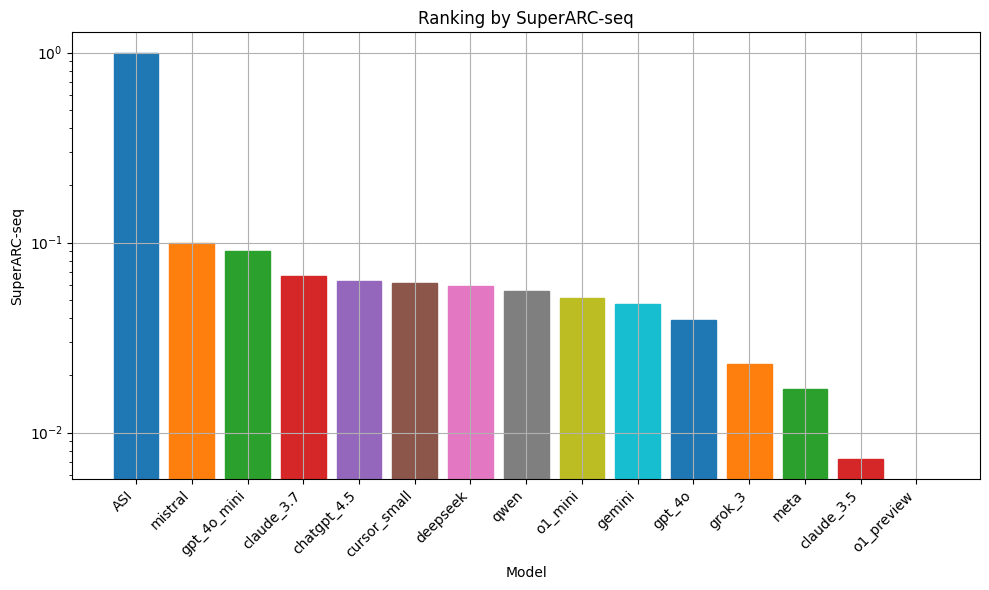

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Sort values in descending order
sorted_df = df_ranking2.sort_values('tst', ascending=False)
# Create bar plot using Model column with default color cycle
bars = plt.bar(range(len(sorted_df)), sorted_df['tst'])
# Set different colors for each bar using default color cycle
for i, bar in enumerate(bars):
    bar.set_color(f'C{i}')
plt.grid(True)
plt.title('Ranking by SuperARC-seq')
plt.xlabel('Model')
plt.ylabel('SuperARC-seq')
# Set y-axis to log scale
plt.yscale('log')
# Set x-tick labels with model names
plt.xticks(range(len(sorted_df)), sorted_df['Model'], rotation=45, ha='right')
plt.tight_layout()
plt.show()


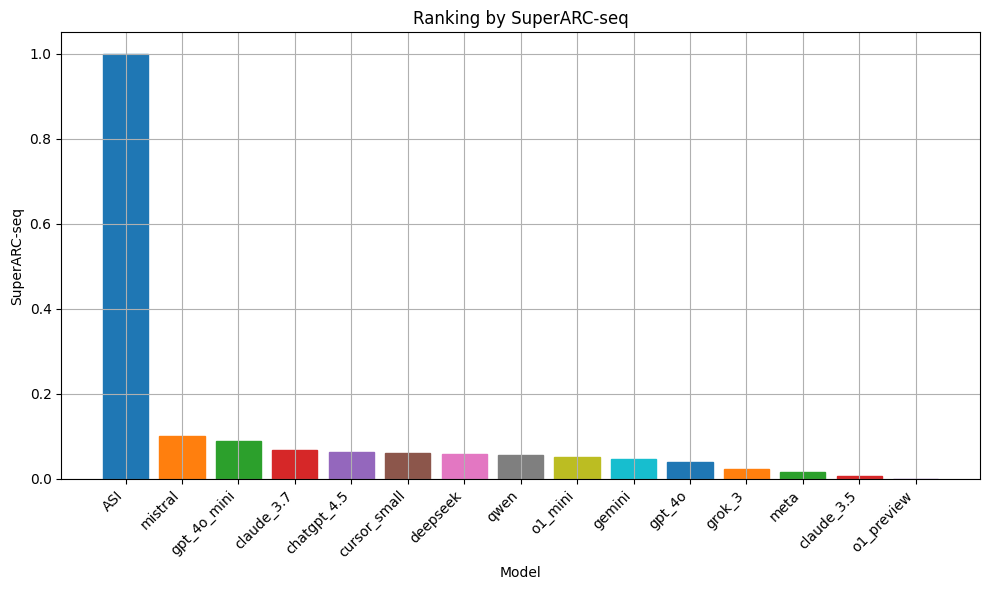

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Sort values in descending order
sorted_df = df_ranking2.sort_values('tst', ascending=False)
# Create bar plot using Model column with default color cycle
bars = plt.bar(range(len(sorted_df)), sorted_df['tst'])
# Set different colors for each bar using default color cycle
for i, bar in enumerate(bars):
    bar.set_color(f'C{i}')
plt.grid(True)
plt.title('Ranking by SuperARC-seq')
plt.xlabel('Model')
plt.ylabel('SuperARC-seq')

# Set x-tick labels with model names
plt.xticks(range(len(sorted_df)), sorted_df['Model'], rotation=45, ha='right')
plt.tight_layout()
plt.show()